In [ ]:
# 런타임: GPU 권장 (런타임 > 변경 > 하드웨어 가속기: GPU)
!nvidia-smi

Fri Nov 14 07:52:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics -q

In [ ]:
# 필요한 라이브러리 불러오기
# YOLO 모델 사용
from ultralytics import YOLO
import os
from pathlib import Path
from IPython.display import Image, display
import yaml

In [ ]:
import torch
import random
import numpy as np

# 시드 값 정의
SEED = 42

# 난수 생성기 고정 함수 정의
def set_reproducibility_seed(seed_value):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)

  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

# 함수 실행
set_reproducibility_seed(SEED)

print(f" 랜덤 시드가 {SEED}로 설정되었습니다.")

 랜덤 시드가 42로 설정되었습니다.


In [ ]:
# Google Drive에 연결
from google.colab import drive
drive.mount('/content/drive')

# 데이터셋 파일 경로
dataset_zip = '/content/drive/MyDrive/Varroa Mites Detector.v1ii.yolov11'

# 압축 풀 위치
extract_path = '/content/dataset'

# ZIP 파일 압축 해제
print(f" 압축 해제 중: {dataset_zip}")
!unzip -q "{dataset_zip}" -d {extract_path}

# 데이터셋 구조 확인
print("\n 데이터셋 구조:")
!ls -l {extract_path}

print(" 데이터 준비 완료\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 압축 해제 중: /content/drive/MyDrive/Varroa Mites Detector.v1ii.yolov11
replace /content/dataset/Varroa Mites Detector.v1ii.yolov11/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

 데이터셋 구조:
total 4
drwxrwxrwx 5 root root 4096 Nov 14 07:52 'Varroa Mites Detector.v1ii.yolov11'
 데이터 준비 완료



In [ ]:
import yaml
import os

yaml_path = os.path.join(extract_path, 'Varroa Mites Detector.v1ii.yolov11', 'data.yaml')

# 기존 yaml 파일 읽기
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print(" 원본 data.yaml 내용:")
print(data_config)

# Colab 환경에 맞게 경로 수정
data_config['path'] = os.path.join(extract_path, 'Varroa Mites Detector.v1ii.yolov11')  # /content/dataset/Varroa Mites Detector.v1ii.yolov11

# 상대 경로로 변경 (또는 절대 경로)
data_config['train'] = 'train/images'
data_config['val'] = 'val/images'
data_config['test'] = 'test/images'

# 수정된 내용 저장
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print("\n 수정된 data.yaml 내용:")
with open(yaml_path, 'r') as f:
    print(f.read())

# 경로 검증
print("\n 경로 검증:")
for split in ['train', 'val', 'test']:
    full_path = os.path.join(data_config['path'], data_config[split])
    exists = os.path.exists(full_path)
    status = ' 존재' if exists else ' 없음'
    print(f"  {split:5s}: {full_path:60s} {status}")

 원본 data.yaml 내용:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['varroa-mite'], 'roboflow': {'workspace': 'jinhyeok-pdyrj', 'project': 'varroa-mites-detector-uzv5u', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/jinhyeok-pdyrj/varroa-mites-detector-uzv5u/dataset/1'}}

 수정된 data.yaml 내용:
names:
- varroa-mite
nc: 1
path: /content/dataset/Varroa Mites Detector.v1ii.yolov11
roboflow:
  license: CC BY 4.0
  project: varroa-mites-detector-uzv5u
  url: https://universe.roboflow.com/jinhyeok-pdyrj/varroa-mites-detector-uzv5u/dataset/1
  version: 1
  workspace: jinhyeok-pdyrj
test: test/images
train: train/images
val: val/images


 경로 검증:
  train: /content/dataset/Varroa Mites Detector.v1ii.yolov11/train/images  존재
  val  : /content/dataset/Varroa Mites Detector.v1ii.yolov11/val/images  존재
  test : /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images  존재


In [ ]:
# 3. 기존 YOLO 모델로 성능 확인(Inference)

# 3-1. Pre-trained 모델 로드
print("\n 3-1. 사전 학습된 모델 불러오기")
model_pretrained = YOLO('yolo11n.pt') # 가장 가벼운 nano 모델"
print(" yolov11n.pt 모델 로드 완료")


 3-1. 사전 학습된 모델 불러오기
 yolov11n.pt 모델 로드 완료


In [ ]:
# 3-2. Test 데이터로 추론
print("\n 3-2. Test 데이터로 추론 수행")

# Augmentation 사용 안 함(원본 데이터만 사용)
test_results = model_pretrained.predict(
    source=os.path.join(data_config['path'], data_config['test']),   # Test Image 경로 (수정됨)
    save=True,                  # 결과 이미지 저장
    save_txt=True,              # 탐지 좌표 txt로 저장
    conf=0.25,                  # 신뢰도 25% 이상만 탐지
    project='runs/inference',   # 결과 저장 폴더
    name='exp3_pretrained',     # 실험 이름
    exist_ok=True               # 기존 폴더 덮어쓰기 허용
)

print(" Inference 완료 ")
print(f" 결과 저장 위치: runs/inference/exp3_pretrained")


 3-2. Test 데이터로 추론 수행

image 1/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6703-525-1_png.rf.1d50b09d8b06d81b7a37c65cf7005d65.jpg: 640x384 1 bird, 98.6ms
image 2/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6721-3945-1_png.rf.7f13b925298495806bd9ddb846528129.jpg: 640x384 1 giraffe, 9.4ms
image 3/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6730-7005-1_png.rf.0af629899ef81b5c29a949b6add0e07a.jpg: 640x384 1 teddy bear, 9.5ms
image 4/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6810-14685-1_png.rf.8022ed5f29dcea0784f2fb73486fa4d4.jpg: 640x384 (no detections), 9.2ms
image 5/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6812-14700-1_png

In [ ]:
# data.yaml 경로 수정

# extract_path는 이미 '/content/dataset'으로 설정되어 있음
# data.yaml 파일은 '/content/dataset/Varroa Mites Detector.v1ii.yolov11/data.yaml'에 위치해야 함
yaml_path = os.path.join(extract_path, 'Varroa Mites Detector.v1ii.yolov11', 'data.yaml')

# 기존 yaml 파일 읽기
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Colab 환경에 맞게 경로 수정
# data_config['path']는 데이터셋의 루트 경로를 가리켜야 함
data_config['path'] = os.path.join(extract_path, 'Varroa Mites Detector.v1ii.yolov11')
data_config['train'] = 'train/images'
data_config['val'] = 'val/images'
data_config['test'] = 'test/images'

# 수정된 내용 저장
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(" data.yaml 경로 수정 완료 ")

# 3-3. Test 성능 평가
print(" 3-3. Test 데이터셋 성능 평가 ")

test_metrics_pretrained = model_pretrained.val(
    data=yaml_path,
    split='test',
    batch=16,
    imgsz=640,
    conf=0.001,
    iou=0.6,
    project='runs/test',
    name='exp3_pretrained'
)

# 성능 지표 출력
print(" 실험 3 결과 (Pre-trained 모델) ")
print(f"mAP50:     {test_metrics_pretrained.box.map50:.4f} ")
print(f"mAP50-95:  {test_metrics_pretrained.box.map:.4f} ")
print(f"Precision: {test_metrics_pretrained.box.mp:.4f} ")
print(f"Recall:    {test_metrics_pretrained.box.mr:.4f}")

 data.yaml 경로 수정 완료 
 3-3. Test 데이터셋 성능 평가 
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 427.8±131.9 MB/s, size: 8.2 KB)
val: Scanning /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/labels.cache... 598 images, 358 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 598/598 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 15.0it/s 2.5s
                   all        598        303    0.00036     0.0033   0.000182   9.12e-05
                person        240        303    0.00036     0.0033   0.000182   9.12e-05
Speed: 0.5ms preprocess, 1.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/test/exp3_pretrained2
 실험 3 결과 (Pre-trained 모델) 
mAP50:     0.0002 
mAP50-95:  0.0001 
Precision: 0.0004 
Recall:    0.0033


In [ ]:
# 실험 4-1: Fine-tuning (전이 학습)
print(" 실험 4번: 내 데이터로 Fine-tuning")

# 새 모델 로드
model_finetune = YOLO('yolo11n.pt')

# 학습 시작
train_results = model_finetune.train(
    data=yaml_path,
    epochs=30,            # 최대 30 epochs
    patience=7,           # 7번 개선 없으면 조기 종료
    batch=32,
    imgsz=640,

    # Augmentation 설정 (Train 시에만 적용)
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,

    mixup=0.1,     # 추가

    # 학습 설정
    optimizer='AdamW',
    lr0=0.0001,
    save=True,
    save_period=10,

    # 결과 저장
    project='runs/train',
    name='exp4_finetuned',
    exist_ok=True
)

print(" Fine-tuning 완료 ")
print(" 학습 결과: runs/train/exp4_finetuned ")

 실험 4번: 내 데이터로 Fine-tuning
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/Varroa Mites Detector.v1ii.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp4_finetuned, nbs=64, nms=False, opset=None, optimize=False, op

In [ ]:
# 실험 4-2: Best 모델 로드

# Best 모델 경로
best_model_path = 'runs/train/exp4_finetuned/weights/best.pt'

# 파일이 있는지 확인
if not os.path.exists(best_model_path):
    print('오류: 모델 파일이 없습니다.')
    print('먼저 Fine-tuning을 실행하세요.')
else:
    # 모델 로드
    model_best = YOLO(best_model_path)
    print('모델 로드 완료')

    # Validation 성능 확인
    print('')
    print('Validation 성능 (참고용):')
    val_metrics = model_best.val(data=yaml_path, split='val', batch=16, imgsz=640)

    print(f'mAP50: {val_metrics.box.map50:.4f}')
    print(f'mAP50-95: {val_metrics.box.map:.4f}')

    # Test 성능 평가 (최종)
    print('')
    print('실험 4-3: Test 성능 평가')
    test_metrics_finetuned = model_best.val(
        data=yaml_path,
        split='test',
        batch=16,
        imgsz=640,
        conf=0.001,
        iou=0.6
    )

    print('')
    print('Fine-tuned 모델 결과:')
    print(f'mAP50: {test_metrics_finetuned.box.map50:.4f}')
    print(f'mAP50-95: {test_metrics_finetuned.box.map:.4f}')
    print(f'Precision: {test_metrics_finetuned.box.mp:.4f}')
    print(f'Recall: {test_metrics_finetuned.box.mr:.4f}')

모델 로드 완료

Validation 성능 (참고용):
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 348.4±129.2 MB/s, size: 7.8 KB)
val: Scanning /content/dataset/Varroa Mites Detector.v1ii.yolov11/val/labels.cache... 1204 images, 784 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1204/1204 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 76/76 17.7it/s 4.3s
                   all       1204        543      0.856      0.786      0.865      0.411
Speed: 0.4ms preprocess, 1.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/runs/detect/val
mAP50: 0.8646
mAP50-95: 0.4111

실험 4-3: Test 성능 평가
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4

In [ ]:
 # 성능 비교
print('실험 3 vs 실험 4 비교:')
diff = test_metrics_finetuned.box.map50 - test_metrics_pretrained.box.map50

print(f'Pre-trained mAP50: {test_metrics_pretrained.box.map50:.4f}')
print(f'Fine-tuned mAP50: {test_metrics_finetuned.box.map50:.4f}')
print(f'차이: {diff:+.4f}')

if diff > 0:
    print('결과: 성능 향상!')
else:
    print('결과: 성능 하락 - 추가 학습 필요')

실험 3 vs 실험 4 비교:
Pre-trained mAP50: 0.0002
Fine-tuned mAP50: 0.8585
차이: +0.8583
결과: 성능 향상!


In [ ]:
# 결과 시각화

import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path
from collections import Counter
from IPython.display import Image, display

print('결과 시각화 시작')

# 1. Fine-tuned 모델로 추론
print('')
print('단계 1: Fine-tuned 모델로 Test 추론')

results_finetuned = model_best.predict(
    source=os.path.join(data_config['path'], data_config['test']),
    save=True,
    conf=0.25,
    project='runs/inference',
    name='exp4_finetuned',
    exist_ok=True
)

print('추론 완료')

결과 시각화 시작

단계 1: Fine-tuned 모델로 Test 추론

image 1/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6703-525-1_png.rf.1d50b09d8b06d81b7a37c65cf7005d65.jpg: 640x384 (no detections), 21.5ms
image 2/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6721-3945-1_png.rf.7f13b925298495806bd9ddb846528129.jpg: 640x384 (no detections), 9.5ms
image 3/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6730-7005-1_png.rf.0af629899ef81b5c29a949b6add0e07a.jpg: 640x384 1 varroa-mite, 9.9ms
image 4/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_glass-mp4-bee_id_6810-14685-1_png.rf.8022ed5f29dcea0784f2fb73486fa4d4.jpg: 640x384 (no detections), 9.5ms
image 5/598 /content/dataset/Varroa Mites Detector.v1ii.yolov11/test/images/2017-08-28_09-30-00-1_500_dirty_

In [ ]:
# 2. 탐지 클래스 분석
print('')
print('단계 2: 탐지 클래스 분석')

def analyze_results(results, name):
    """탐지 결과 분석 함수"""
    classes = []
    detected = 0
    not_detected = 0

    for result in results:
        if len(result.boxes) > 0:
            detected += 1
            for box in result.boxes:
                cls_id = int(box.cls[0])
                cls_name = result.names[cls_id]
                classes.append(cls_name)
        else:
            not_detected += 1

    counter = Counter(classes)

    print(f'{name} 결과:')
    print(f'총 이미지: {len(results)}장')
    print(f'탐지 성공: {detected}장')
    print(f'탐지 실패: {not_detected}장')
    print(f'총 객체: {len(classes)}개')

    if counter:
        print('탐지된 클래스 (상위 5개):')
        for cls, count in counter.most_common(5):
            print(f'  {cls}: {count}개')

    return counter


단계 2: 탐지 클래스 분석


In [ ]:
# Pre-trained 결과
print('')
print('Pre-trained 모델:')
pre_classes = analyze_results(test_results, 'Pre-trained')

# Fine-tuned 결과
print('')
print('Fine-tuned 모델:')
fine_classes = analyze_results(results_finetuned, 'Fine-tuned')


Pre-trained 모델:
Pre-trained 결과:
총 이미지: 598장
탐지 성공: 336장
탐지 실패: 262장
총 객체: 372개
탐지된 클래스 (상위 5개):
  dog: 88개
  bird: 73개
  cat: 39개
  vase: 39개
  giraffe: 30개

Fine-tuned 모델:
Fine-tuned 결과:
총 이미지: 598장
탐지 성공: 230장
탐지 실패: 368장
총 객체: 306개
탐지된 클래스 (상위 5개):
  varroa-mite: 306개



단계 3: 결과 이미지 비교
Pre-trained 이미지: 598장
Fine-tuned 이미지: 598장
비교 이미지 저장: comparison.png


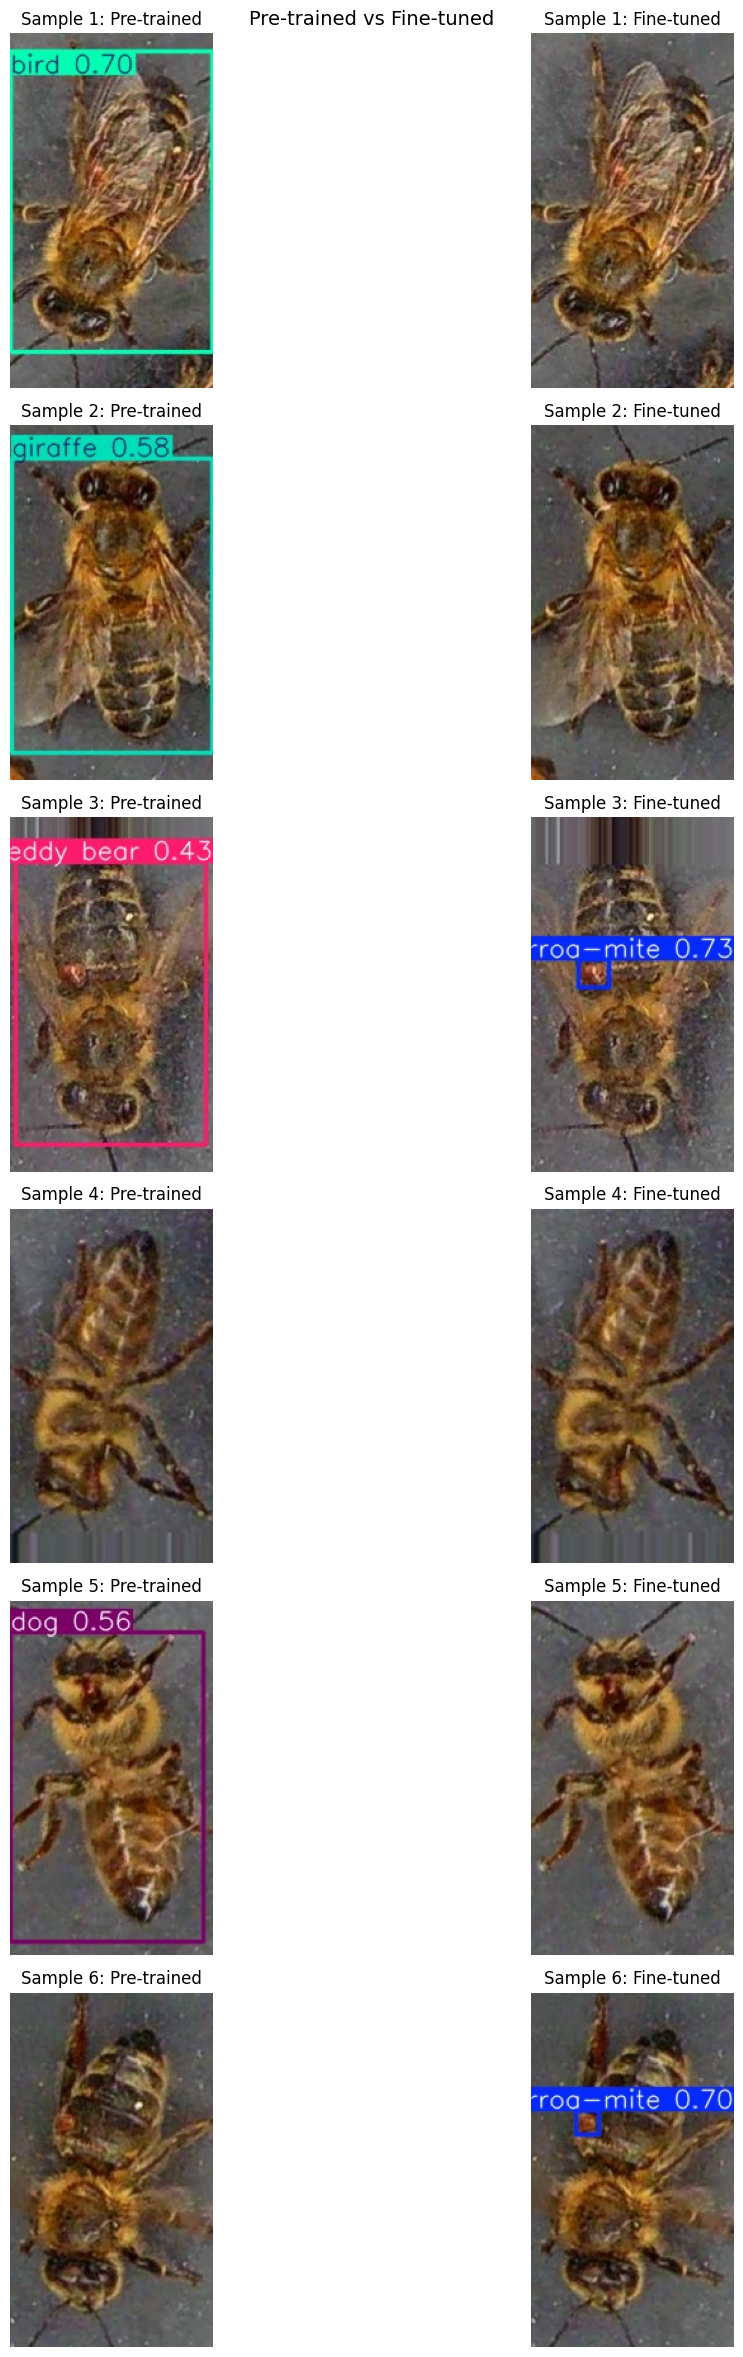

In [ ]:
# 3. 이미지 비교
print('')
print('단계 3: 결과 이미지 비교')

pre_dir = Path('runs/inference/exp3_pretrained')
fine_dir = Path('runs/inference/exp4_finetuned')

pre_images = sorted(pre_dir.glob('*.jpg'))
fine_images = sorted(fine_dir.glob('*.jpg'))

print(f'Pre-trained 이미지: {len(pre_images)}장')
print(f'Fine-tuned 이미지: {len(fine_images)}장')

if len(pre_images) > 0 and len(fine_images) > 0:
    # 6장 비교
    num = min(6, len(pre_images), len(fine_images))

    fig, axes = plt.subplots(num, 2, figsize=(14, 4*num))
    if num == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Pre-trained vs Fine-tuned', fontsize=14)

    for i in range(num):
        # 이미지 읽기
        img1 = cv2.imread(str(pre_images[i]))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        img2 = cv2.imread(str(fine_images[i]))
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # 그리기
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f'Sample {i+1}: Pre-trained')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f'Sample {i+1}: Fine-tuned')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('comparison.png', dpi=150)
    print('비교 이미지 저장: comparison.png')
    plt.show()

In [ ]:
# YOLOv11 small 모델 실험

In [ ]:
# 실험 5-1: Fine-tuning (전이 학습)
print(" 실험 4번: 내 데이터로 Fine-tuning")

# 새 모델 로드(YOLOv11 small)
model_finetune_s = YOLO('yolo11s.pt')

# 학습 시작
train_results_s = model_finetune_s.train(
    data=yaml_path,
    epochs=30,            # 최대 30 epochs
    patience=7,           # 7번 개선 없으면 조기 종료
    batch=32,
    imgsz=640,

    # Augmentation 설정 (Train 시에만 적용)
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,

    mixup=0.1,     # 추가

    # 학습 설정
    optimizer='AdamW',
    lr0=0.0001,
    save=True,
    save_period=10,

    # 결과 저장
    project='runs/train',
    name='exp4_finetuned_s',
    exist_ok=True
)

print(" Fine-tuning 완료 ")
print(" 학습 결과: runs/train/exp4_finetuned_s ")

 실험 4번: 내 데이터로 Fine-tuning
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/Varroa Mites Detector.v1ii.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp4_finetuned_s, nbs=64, nms=False, opset=None, optimize=False, 

In [ ]:
# 실험 5-2: Best 모델 로드

# Best 모델 경로
best_model_path_s = 'runs/train/exp4_finetuned_s/weights/best.pt'

# 파일이 있는지 확인
if not os.path.exists(best_model_path_s):
    print('오류: 모델 파일이 없습니다.')
    print('먼저 Fine-tuning을 실행하세요.')
else:
    # 모델 로드
    model_best_s = YOLO(best_model_path_s)
    print('모델 로드 완료')

    # Validation 성능 확인
    print('')
    print('Validation 성능 (참고용):')
    val_metrics_s = model_best_s.val(data=yaml_path, split='val', batch=16, imgsz=640)

    print(f'mAP50: {val_metrics_s.box.map50:.4f}')
    print(f'mAP50-95: {val_metrics_s.box.map:.4f}')

    # Test 성능 평가 (최종)
    print('')
    print('실험 5-3: Test 성능 평가')
    test_metrics_finetuned_s = model_best_s.val(
        data=yaml_path,
        split='test',
        batch=16,
        imgsz=640,
        conf=0.001,
        iou=0.6
    )

    print('')
    print('Fine-tuned 모델 결과:')
    print(f'mAP50: {test_metrics_finetuned_s.box.map50:.4f}')
    print(f'mAP50-95: {test_metrics_finetuned_s.box.map:.4f}')
    print(f'Precision: {test_metrics_finetuned_s.box.mp:.4f}')
    print(f'Recall: {test_metrics_finetuned_s.box.mr:.4f}')

모델 로드 완료

Validation 성능 (참고용):
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 372.2±128.4 MB/s, size: 7.8 KB)
val: Scanning /content/dataset/Varroa Mites Detector.v1ii.yolov11/val/labels.cache... 1204 images, 784 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1204/1204 2.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 76/76 18.5it/s 4.1s
                   all       1204        543        0.9       0.81       0.89      0.423
Speed: 0.4ms preprocess, 1.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /content/runs/detect/val3
mAP50: 0.8899
mAP50-95: 0.4227

실험 5-3: Test 성능 평가
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read:

In [ ]:
# YOLOv11 medium 모델 실험

In [ ]:
# 실험 6-1: Fine-tuning (전이 학습)
print(" 실험 4번: 내 데이터로 Fine-tuning")

# 새 모델 로드(YOLOv11 medium)
model_finetune_m = YOLO('yolo11m.pt')

# 학습 시작
train_results_m = model_finetune_m.train(
    data=yaml_path,
    epochs=30,            # 최대 30 epochs
    patience=7,           # 7번 개선 없으면 조기 종료
    batch=32,
    imgsz=640,

    # Augmentation 설정 (Train 시에만 적용)
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,

    mixup=0.1,     # 추가

    # 학습 설정
    optimizer='AdamW',
    lr0=0.0001,
    save=True,
    save_period=10,

    # 결과 저장
    project='runs/train',
    name='exp4_finetuned_m',
    exist_ok=True
)

print(" Fine-tuning 완료 ")
print(" 학습 결과: runs/train/exp4_finetuned_m ")

 실험 4번: 내 데이터로 Fine-tuning
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/Varroa Mites Detector.v1ii.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp4_finetuned_m, nbs=64, nms=False, opset=None, optimize=False, 

In [ ]:
# 실험 6-2: Best 모델 로드

# Best 모델 경로
best_model_path_m = 'runs/train/exp4_finetuned_m/weights/best.pt'

# 파일이 있는지 확인
if not os.path.exists(best_model_path_m):
    print('오류: 모델 파일이 없습니다.')
    print('먼저 Fine-tuning을 실행하세요.')
else:
    # 모델 로드
    model_best_m = YOLO(best_model_path_m)
    print('모델 로드 완료')

    # Validation 성능 확인
    print('')
    print('Validation 성능 (참고용):')
    val_metrics_m = model_best_m.val(data=yaml_path, split='val', batch=16, imgsz=640)

    print(f'mAP50: {val_metrics_m.box.map50:.4f}')
    print(f'mAP50-95: {val_metrics_m.box.map:.4f}')

    # Test 성능 평가 (최종)
    print('')
    print('실험 6-3: Test 성능 평가')
    test_metrics_finetuned_m = model_best_m.val(
        data=yaml_path,
        split='test',
        batch=16,
        imgsz=640,
        conf=0.001,
        iou=0.6
    )

    print('')
    print('Fine-tuned 모델 결과:')
    print(f'mAP50: {test_metrics_finetuned_m.box.map50:.4f}')
    print(f'mAP50-95: {test_metrics_finetuned_m.box.map:.4f}')
    print(f'Precision: {test_metrics_finetuned_m.box.mp:.4f}')
    print(f'Recall: {test_metrics_finetuned_m.box.mr:.4f}')

모델 로드 완료

Validation 성능 (참고용):
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 380.0±135.6 MB/s, size: 7.8 KB)
val: Scanning /content/dataset/Varroa Mites Detector.v1ii.yolov11/val/labels.cache... 1204 images, 784 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1204/1204 1.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 76/76 15.4it/s 4.9s
                   all       1204        543      0.848      0.818      0.874      0.419
Speed: 0.4ms preprocess, 1.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /content/runs/detect/val5
mAP50: 0.8740
mAP50-95: 0.4192

실험 6-3: Test 성능 평가
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read

Test 이미지 수: 598

====== Best 모델 성능 비교 ======

▶ Best-N
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input by 255.
WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.704082489013672. Dividing input b

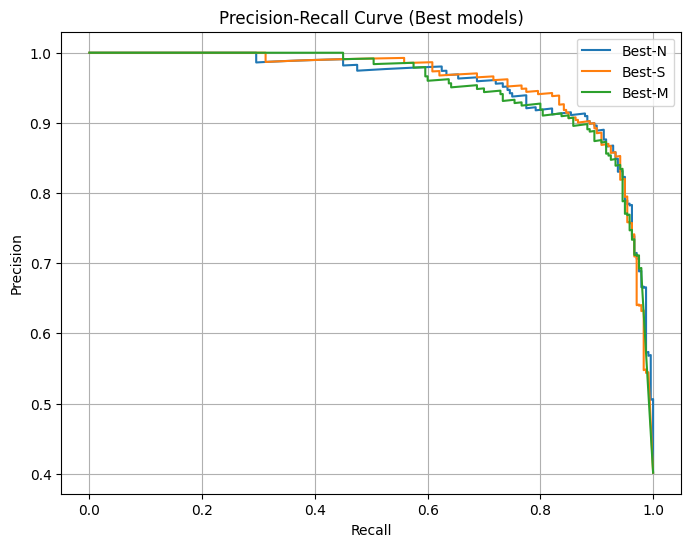

In [ ]:
# ============================================
# Best 모델 3개(nano, small, medium) 성능 비교
# ============================================

from ultralytics import YOLO
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# --------------------------
# 🔹 1) 모델 로드
# --------------------------
model_n = YOLO(best_model_path)      # Best(n)
model_s = YOLO(best_model_path_s)    # Best(s)
model_m = YOLO(best_model_path_m)    # Best(m)

models = [
    ("Best-N", model_n),
    ("Best-S", model_s),
    ("Best-M", model_m)
]

# --------------------------
# 🔹 2) Params / GFLOPs 계산
# --------------------------
def get_params(model):
    return sum(p.numel() for p in model.model.parameters()) / 1e6

def get_flops(model, imgsz=640):
    # 단일 forward pass FLOPs 계산
    try:
        return model.model.info(verbose=False)['flops'] / 1e9  # GFLOPs
    except:
        return None

# --------------------------
# 🔹 3) 추론 속도 (ms, FPS)
# --------------------------
def measure_speed(model, imgsz=640, runs=20):
    dummy = torch.randn(1, 3, imgsz, imgsz).to(model.device)
    times = []

    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            model(dummy, verbose=False)
            times.append(time.time() - start)

    avg_ms = np.mean(times) * 1000
    fps = 1000 / avg_ms
    return avg_ms, fps

# --------------------------
# 🔹 4) PR Curve 계산 (test dataset 기준)
# --------------------------
from sklearn.metrics import precision_recall_curve

def compute_pr_curve(model, test_imgs):
    y_true = []
    y_score = []

    for img in test_imgs:
        label_file = str(img).replace('images', 'labels').replace('.jpg', '.txt')
        has_object = os.path.exists(label_file) and os.path.getsize(label_file) > 0

        result = model.predict(str(img), conf=0.001, verbose=False)

        if len(result[0].boxes) > 0:
            score = float(result[0].boxes.conf.max())
        else:
            score = 0.0

        y_true.append(1 if has_object else 0)
        y_score.append(score)

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return precision, recall

# --------------------------
# 🔹 Test 이미지 불러오기
# --------------------------
test_imgs = list(Path(os.path.join(data_config['path'], data_config['test'])).glob('*.jpg'))
print("Test 이미지 수:", len(test_imgs))


# --------------------------
# 🔹 모델별 결과 출력 및 저장
# --------------------------
print("\n====== Best 모델 성능 비교 ======\n")

results = {}

for name, model in models:
    print(f"▶ {name}")

    params = get_params(model)
    flops  = get_flops(model)
    avg_ms, fps = measure_speed(model)

    results[name] = {
        "params(M)": params,
        "GFLOPs": flops,
        "Inference(ms)": avg_ms,
        "FPS": fps
    }

    print(f"  파라미터 수 (M): {params:.2f}")
    print(f"  GFLOPs        : {flops:.2f}" if flops else "  GFLOPs: 계산 불가")
    print(f"  추론 속도(ms) : {avg_ms:.2f} ms")
    print(f"  FPS           : {fps:.2f} fps\n")

# --------------------------
# 🔹 PR Curve 시각화
# --------------------------
plt.figure(figsize=(8,6))

for name, model in models:
    precision, recall = compute_pr_curve(model, test_imgs)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Best models)")
plt.legend()
plt.grid(True)
plt.savefig("pr_curve_best_models.png", dpi=150)
plt.show()


In [ ]:
# Best 모델 선택 후 평가 및 K-Fold 검증

전체 이미지: 5340장

Fold 1/5 시작
  Train: 4272장, Val: 1068장
  데이터 준비 완료
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold_1.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fold_1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overl

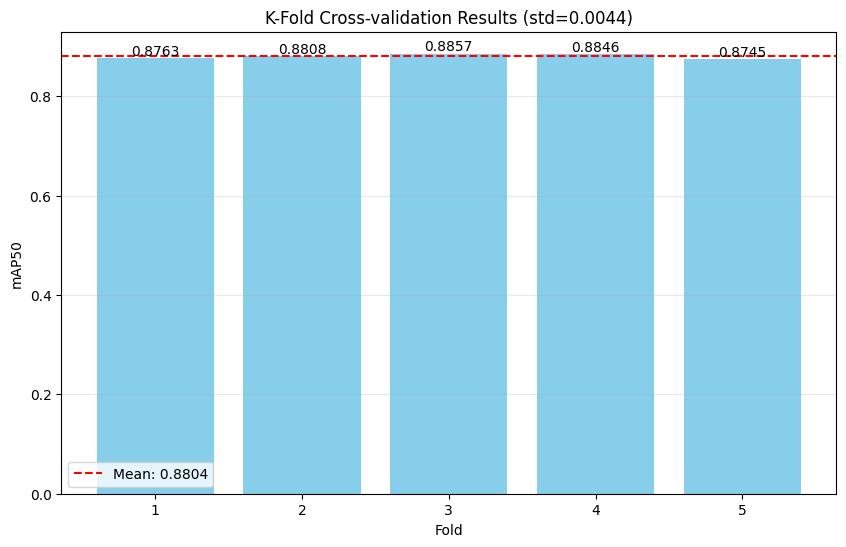


K-Fold 완료


In [ ]:
#  수정된 셀 14: K-Fold Cross-validation

from sklearn.model_selection import KFold
import shutil

# K-Fold Cross-validation 시작

# 설정
k_folds = 5

# 전체 데이터 수집
# data_config['path']는 이미 '/content/dataset/Varroa Mites Detector.v1ii.yolov11'로 설정되어 있음
base_dataset_path = Path(data_config['path'])
train_dir = base_dataset_path / 'train'
val_dir = base_dataset_path / 'val'

# 이미지와 라벨 수집
train_imgs = list((train_dir / 'images').glob('*.jpg'))
train_lbls = list((train_dir / 'labels').glob('*.txt'))
val_imgs = list((val_dir / 'images').glob('*.jpg'))
val_lbls = list((val_dir / 'labels').glob('*.txt'))

# 모든 데이터 합치기
all_imgs = train_imgs + val_imgs
all_lbls = train_lbls + val_lbls

print(f'전체 이미지: {len(all_imgs)}장')

# 이미지 경로만 배열로 변환
img_paths = np.array([str(p) for p in all_imgs])

# KFold 설정
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

# 결과 저장
fold_results = []

# 각 Fold 실행
for fold_num, (train_idx, val_idx) in enumerate(kfold.split(img_paths)):
    print('')
    print(f'Fold {fold_num + 1}/{k_folds} 시작')

    # Fold별 디렉토리 생성
    fold_base = Path(extract_path) / f'kfold_{fold_num + 1}'
    fold_train_img = fold_base / 'train' / 'images'
    fold_train_lbl = fold_base / 'train' / 'labels'
    fold_val_img = fold_base / 'val' / 'images'
    fold_val_lbl = fold_base / 'val' / 'labels'

    # 폴더 생성
    fold_train_img.mkdir(parents=True, exist_ok=True)
    fold_train_lbl.mkdir(parents=True, exist_ok=True)
    fold_val_img.mkdir(parents=True, exist_ok=True)
    fold_val_lbl.mkdir(parents=True, exist_ok=True)

    print(f'  Train: {len(train_idx)}장, Val: {len(val_idx)}장')

    # Train 데이터 복사
    for idx in train_idx:
        img_path = Path(img_paths[idx])
        lbl_path = img_path.parent.parent / 'labels' / img_path.name.replace('.jpg', '.txt')

        # 복사
        shutil.copy(img_path, fold_train_img / img_path.name)
        if lbl_path.exists():
            shutil.copy(lbl_path, fold_train_lbl / lbl_path.name)

    # Val 데이터 복사
    for idx in val_idx:
        img_path = Path(img_paths[idx])
        lbl_path = img_path.parent.parent / 'labels' / img_path.name.replace('.jpg', '.txt')

        # 복사
        shutil.copy(img_path, fold_val_img / img_path.name)
        if lbl_path.exists():
            shutil.copy(lbl_path, fold_val_lbl / lbl_path.name)

    # Fold별 yaml 파일 생성
    fold_yaml = {
        'path': str(fold_base),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 1,
        'names': ['varroa_mite']
    }

    fold_yaml_path = f'kfold_{fold_num + 1}.yaml'
    with open(fold_yaml_path, 'w') as f:
        yaml.dump(fold_yaml, f)

    print(f'  데이터 준비 완료')

    # 모델 학습
    model = YOLO('yolo11s.pt')

    results = model.train(
        data=fold_yaml_path,  # Fold별 yaml 사용!
        epochs=30,            # 최대 30 epochs
        patience=7,           # 7번 개선 없으면 조기 종료
        batch=32,
        imgsz=640,
        project='runs/kfold',
        name=f'fold_{fold_num + 1}',
        exist_ok=True,
        verbose=False
    )

    # 평가
    val_metrics = model.val(data=fold_yaml_path, split='val')

    # 결과 저장
    map50 = float(val_metrics.box.map50)
    fold_results.append(map50)

    print(f'  Fold {fold_num + 1} mAP50: {map50:.4f}')

# 통계 계산
mean_map50 = np.mean(fold_results)
std_map50 = np.std(fold_results)

print('')
print('K-Fold 최종 결과:')
print(f'mAP50: {mean_map50:.4f} +/- {std_map50:.4f}')
print('')
print('각 Fold 결과:')
for i, score in enumerate(fold_results):
    print(f'  Fold {i+1}: {score:.4f}')

# 그래프
plt.figure(figsize=(10, 6))
plt.bar(range(1, k_folds + 1), fold_results, color='skyblue')
plt.axhline(mean_map50, color='red', linestyle='--',
            label=f'Mean: {mean_map50:.4f}')
plt.xlabel('Fold')
plt.ylabel('mAP50')
plt.title(f'K-Fold Cross-validation Results (std={std_map50:.4f})')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 각 막대에 값 표시
for i, score in enumerate(fold_results):
    plt.text(i+1, score, f'{score:.4f}',
             ha='center', va='bottom')

plt.savefig('kfold_results.png', dpi=150)
print('그래프 저장: kfold_results.png')
plt.show()

print('')
print('K-Fold 완료')

In [ ]:
# 셀 18: 통계적 유의성 검정 (Best 모델: YOLOv11s)

from scipy import stats
from ultralytics import YOLO

print('통계 검정 (Best: YOLOv11s)')

# K-Fold 결과 사용 (YOLOv11s로 K-Fold 돌린 결과라고 가정)
if len(fold_results) > 0:
    # 1) Fine-tuned 결과 (K-Fold에서 나온 mAP50 리스트)
    fine_scores = fold_results   # 예: [0.89, 0.90, 0.88, 0.91, 0.89]

    # 2) Pre-trained YOLOv11s 성능 측정
    model_pre_s = YOLO('yolo11s.pt')  # 사전 학습된 small 모델
    test_metrics_pre_s = model_pre_s.val(data=yaml_path, split='val', verbose=False)
    pre_score = float(test_metrics_pre_s.box.map50)

    # 3) one-sample t-test (fine_scores의 평균 vs pre_score)
    t_stat, p_value = stats.ttest_1samp(fine_scores, pre_score)

    print('\nPre-trained YOLOv11s vs Fine-tuned YOLOv11s (K-Fold):')
    print(f'Pre-trained mAP50 : {pre_score:.4f}')
    print(f'Fine-tuned mAP50 : {np.mean(fine_scores):.4f} +/- {np.std(fine_scores):.4f}\n')

    print(f't-statistic: {t_stat:.4f}')
    print(f'p-value    : {p_value:.4f}')

    if p_value < 0.05:
        print('결론: 통계적으로 유의미함 (p < 0.05)')
    else:
        print('결론: 통계적으로 유의미하지 않음')
else:
    print('fold_results가 비어 있습니다. 먼저 YOLOv11s로 K-Fold를 수행하세요.')

통계 검정 (Best: YOLOv11s)
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,443,760 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 330.0±100.1 MB/s, size: 7.9 KB)
val: Scanning /content/dataset/Varroa Mites Detector.v1ii.yolov11/val/labels.cache... 1204 images, 784 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1204/1204 2.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 76/76 15.9it/s 4.8s
                   all       1204        543    0.00108    0.00921   0.000545   0.000273
Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val12

Pre-trained YOLOv11s vs Fine-tuned YOLOv11s (K-Fold):
Pre-trained mAP50 : 0.0005
Fine-tuned mAP50 : 0.8804 +/- 0.0044

t-statistic: 401.0456
p-value    : 0.0000
결론: 통계적으로 유의미함 (p < 0.05)


Confusion Matrix 생성
테스트 이미지 수: 598
그래프 저장: confusion_matrix_best_kfold.png


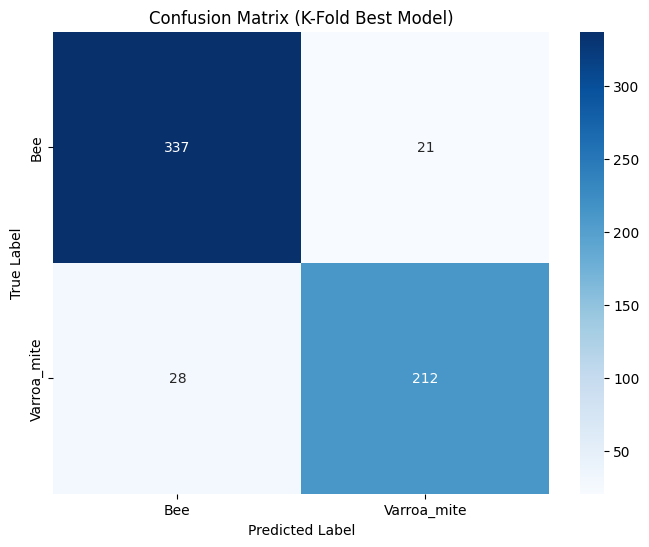


결과 (K-Fold Best 모델 기준):
True Positive (TP): 212
False Positive(FP): 21
False Negative(FN): 28
True Negative (TN): 337
Accuracy         : 0.9181


In [ ]:
# 셀 16: K-Fold Best 모델에 대한 Confusion Matrix

from ultralytics import YOLO
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os

print('Confusion Matrix 생성')

# 🔹 1) K-Fold 결과에서 선택한 최종 Best 모델 경로 지정
#    예시: fold_3가 가장 성능이 좋았다면
BEST_MODEL_PATH = "runs/kfold/fold_3/weights/best.pt"   # ← 여기를 실제 Best 모델 경로로 수정하세요

# 모델 로드
model_best = YOLO(BEST_MODEL_PATH)

# 🔹 2) 실제값과 예측값 저장 리스트
true_labels = []
pred_labels = []

# 🔹 3) Test 이미지들 로드
# data_config['path']  : 예) '/content/dataset/Varroa Mites Detector.v1ii.yolov11'
# data_config['test']  : 예) 'test/images'
test_dir = Path(os.path.join(data_config['path'], data_config['test']))
test_imgs = list(test_dir.glob('*.jpg'))

# 이미지 경로가 비어 있는지 확인
if not test_imgs:
    print("오류: 테스트 이미지를 찾을 수 없습니다. data.yaml의 test 경로를 다시 확인해주세요.")
else:
    print("테스트 이미지 수:", len(test_imgs))

    for img in test_imgs:
        # 🔹 실제 라벨 확인
        #   - labels 폴더의 .txt가 존재하고 파일 크기가 0보다 크면 Varroa 존재(1)
        #   - 없거나 비어 있으면 Bee(0)
        label_file = str(img).replace('images', 'labels').replace('.jpg', '.txt')
        has_object = os.path.exists(label_file) and os.path.getsize(label_file) > 0

        # 🔹 예측 (Best 모델로 추론)
        result = model_best.predict(str(img), verbose=False, conf=0.25)

        #   박스가 하나라도 있으면 Varroa 탐지로 간주
        detected = len(result[0].boxes) > 0

        # 🔹 라벨 저장 (Bee=0, Varroa_mite=1)
        true_labels.append(1 if has_object else 0)
        pred_labels.append(1 if detected else 0)

    # 🔹 4) Confusion Matrix 계산
    cm = confusion_matrix(true_labels, pred_labels)

    # 🔹 5) 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Bee', 'Varroa_mite'],
        yticklabels=['Bee', 'Varroa_mite']
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix (K-Fold Best Model)')
    plt.savefig('confusion_matrix_best_kfold.png', dpi=150)
    print('그래프 저장: confusion_matrix_best_kfold.png')
    plt.show()

    # 🔹 6) 통계 출력
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print('')
    print('결과 (K-Fold Best 모델 기준):')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive(FP): {fp}')
    print(f'False Negative(FN): {fn}')
    print(f'True Negative (TN): {tn}')
    print(f'Accuracy         : {accuracy:.4f}')


Real vs Pred Visualization (20 images, YOLOv11s Best)
시각화 이미지 개수: 20
시각화 저장됨: real_pred_boxes_20imgs_twoline.png


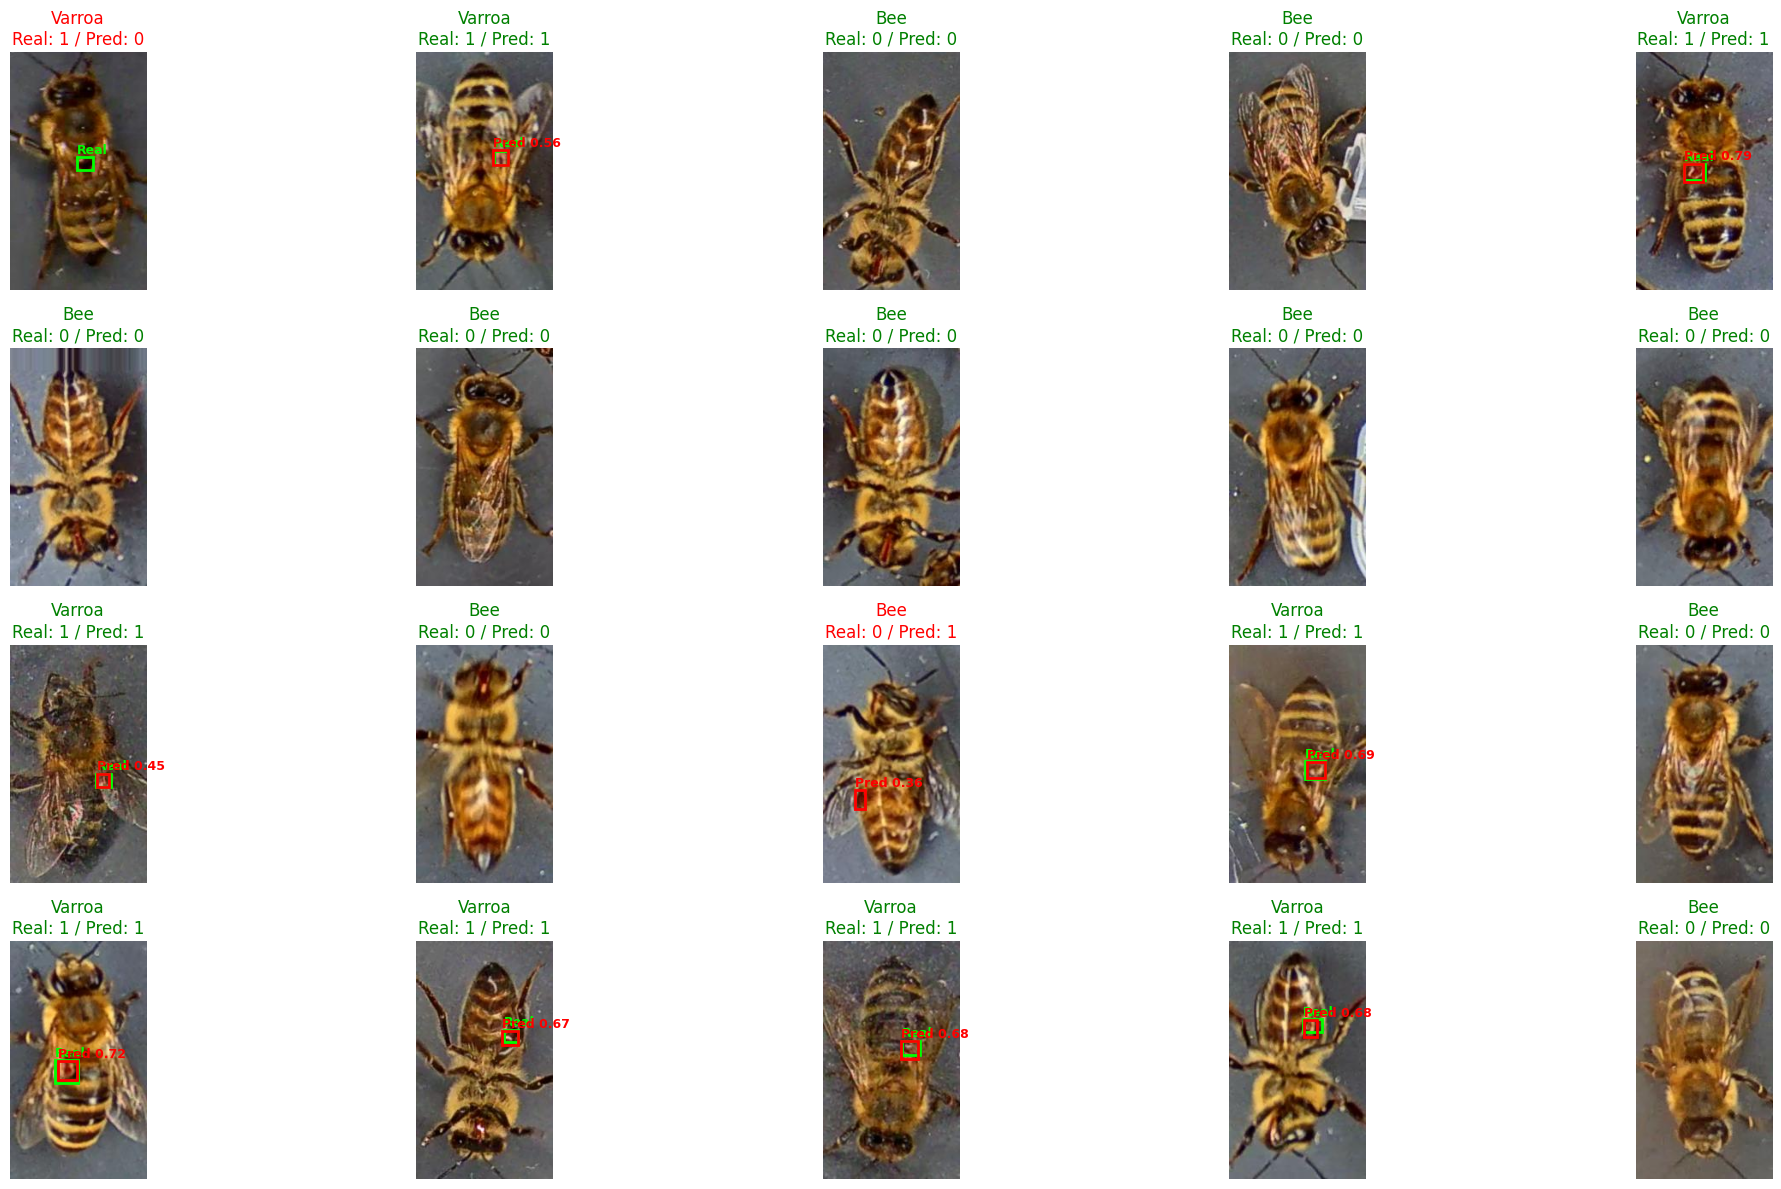

In [ ]:
# 셀: Real 박스 + Pred 박스 + 0/1 시각화 (20개, 제목 2줄)

from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import cv2
import os
import random
import math

print("Real vs Pred Visualization (20 images, YOLOv11s Best)")

# ---------------------------
# 1) Best YOLO11s 모델 로드
# ---------------------------
model = YOLO(best_model_path_s)

# ---------------------------
# 2) 테스트 이미지 불러오기
# ---------------------------
test_dir = Path(os.path.join(data_config['path'], data_config['test']))
test_imgs = list(test_dir.glob("*.jpg"))

if not test_imgs:
    raise FileNotFoundError("❌ 테스트 이미지가 없습니다.")

# 20장 랜덤 선택
sample_imgs = random.sample(test_imgs, min(20, len(test_imgs)))
print(f"시각화 이미지 개수: {len(sample_imgs)}")

# ---------------------------
# 3) 예측 수행
# ---------------------------
results = model.predict(
    [str(p) for p in sample_imgs],
    conf=0.25,
    verbose=False
)

# ---------------------------
# 4) 시각화 시작
# ---------------------------
cols = 5
rows = math.ceil(len(sample_imgs) / cols)

plt.figure(figsize=(22, 12))

for idx, (img_path, res) in enumerate(zip(sample_imgs, results)):

    # =======================
    # (1) 이미지 읽기
    # =======================
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # =======================
    # (2) REAL 박스 읽기
    # =======================
    real_boxes = []
    label_path = str(img_path).replace("images", "labels").replace(".jpg", ".txt")

    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, xc, yc, bw, bh = map(float, line.split())
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h
                real_boxes.append([x1, y1, x2, y2])
        real_binary = 1
        first_line = "Varroa"   # 첫째 줄: Varroa
    else:
        real_binary = 0
        first_line = "Bee"      # 첫째 줄: Bee

    # =======================
    # (3) Pred 박스 가져오기
    # =======================
    pred_boxes = []
    pred_scores = []

    for b in res.boxes.data:
        x1, y1, x2, y2, conf, cls = b.tolist()
        pred_boxes.append([x1, y1, x2, y2])
        pred_scores.append(conf)

    pred_binary = 1 if len(pred_boxes) > 0 else 0

    # =======================
    # (4) 시각화
    # =======================
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_rgb)
    ax = plt.gca()

    # REAL 박스 (Green)
    for (x1, y1, x2, y2) in real_boxes:
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, "Real", color='lime', fontsize=9, weight='bold')

    # Pred 박스 (Red)
    for (box, conf) in zip(pred_boxes, pred_scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"Pred {conf:.2f}", color='red', fontsize=9, weight='bold')

    # =======================
    # (5) 제목 2줄 구성
    # =======================
    match = (real_binary == pred_binary)
    tcolor = "green" if match else "red"

    second_line = f"Real: {real_binary} / Pred: {pred_binary}"

    plt.title(f"{first_line}\n{second_line}", fontsize=12, color=tcolor)
    plt.axis("off")

plt.tight_layout()
plt.savefig("real_pred_boxes_20imgs_twoline.png", dpi=150)
print("시각화 저장됨: real_pred_boxes_20imgs_twoline.png")

plt.show()